I have used a custom dataset which i already downloaded [link->https://www.kaggle.com/datasets/k5nc137/anime-dataset]

In [1]:
import os
import torch
import torchvision
import torch.nn as nn

from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torch.nn.functional as f
from torchvision.datasets import ImageFolder
import torchvision.transforms as t
from torchvision.utils import save_image

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
img_dir="./Dataset"
print(os.listdir(img_dir))

['Anime Images']


In [3]:
stats=((0.5,0.5,0.5),(0.5,0.5,0.5))

In [4]:
train_dl=ImageFolder(img_dir,transform=t.Compose([
                t.Resize(64),
                t.CenterCrop(64),
                t.ToTensor(),
                t.Normalize(*(stats))]))

In [5]:
train_dl=DataLoader(train_dl,128,shuffle=True,num_workers=3,pin_memory=True)

In [6]:
def denorm(img):
    return img*stats[1][0] +stats[0][0]

In [7]:
def show_img_norm(img):
    fig,ax=plt.subplots(figsize=(16,16))
    ax.set_xticks([]);ax.set_yticks([])
    plt.imshow(make_grid(denorm(img),nrow=16).permute(1,2,0))
def show_img(img):
    fig,ax=plt.subplots(figsize=(16,16))
    ax.set_xticks([]);ax.set_yticks([])
    plt.imshow(make_grid(img,nrow=16).permute(1,2,0))

def show_bth(batch):
    for i,_ in batch:
        show_img_norm(i)
        break

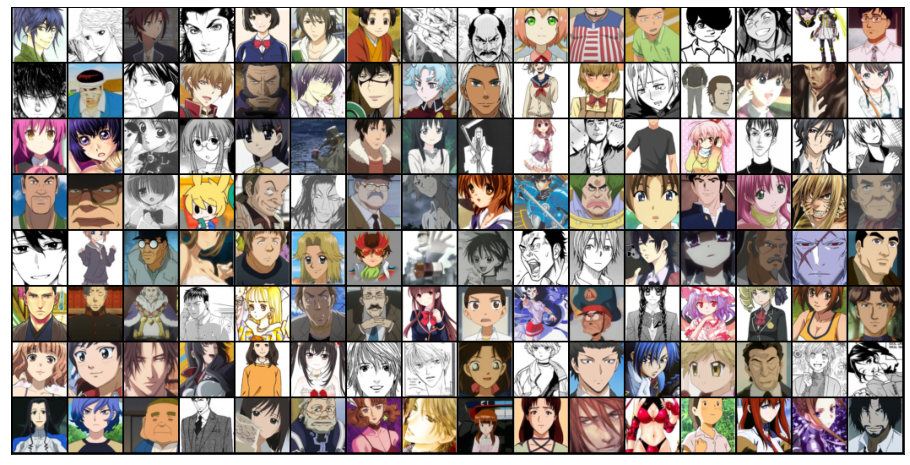

In [8]:
show_bth(train_dl)

In [9]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device)for x in data]
    return data.to(device,non_blocking=True)

class devicedataloader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        for a in self.dl:
            yield to_device(a,device=self.device)

    def __len__(self):
        return len(self.dl)


In [10]:
device=get_default_device()
device

device(type='cuda')

In [11]:
train_dl=devicedataloader(train_dl,device)

In [12]:
discriminator=nn.Sequential(

            nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
            
            nn.Flatten(),
            nn.Sigmoid()
)

In [13]:
discriminator=to_device(discriminator,device)

In [14]:
generator = nn.Sequential(
            nn.ConvTranspose2d(128,512,kernel_size=4,stride=1,padding=0,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
            nn.Tanh()
)

In [15]:
generator=to_device(generator,device)

In [16]:
def train_discriminator(real_img,opt_d):
    opt_d.zero_grad()

    real_preds=discriminator(real_img)
    preds=torch.ones(real_img.size(0),1,device=device)
    real_loss=f.binary_cross_entropy(real_preds,preds)
    real_score=torch.mean(real_loss).item()

    latent=torch.randn(128,128,1,1,device=device)
    fake_img=generator(latent)

    fake_preds=discriminator(fake_img)
    preds=torch.zeros(fake_img.size(0),1,device=device)
    fake_loss=f.binary_cross_entropy(fake_preds,preds)
    fake_score=torch.mean(fake_loss).item()

    loss=real_loss+fake_loss
    loss.backward()
    opt_d.step()

    return loss.item(),real_score,fake_score

In [17]:
def train_generator(opt_g):
    opt_g.zero_grad()

    latent=torch.randn(128,128,1,1,device=device)
    fake_img=generator(latent)
    preds=discriminator(fake_img)
    org_preds=torch.ones(fake_img.size(0),1,device=device)
    loss=f.binary_cross_entropy(preds,org_preds)

    loss.backward()
    opt_g.step()

    return loss.item()

In [18]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [19]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [20]:
fixed_latent = torch.randn(64, 128, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


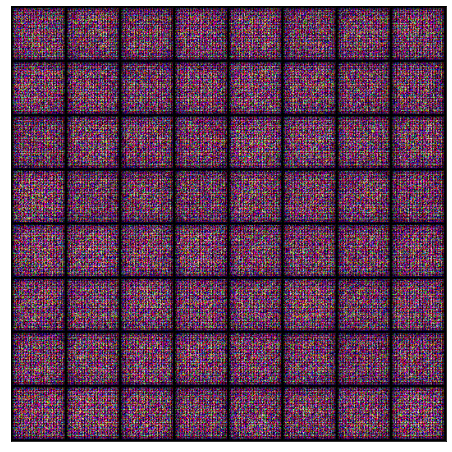

In [21]:
save_samples(0, fixed_latent)

In [22]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in(train_dl):
            
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            
            loss_g = train_generator(opt_g)
            
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores


In [23]:
history = fit(27, 0.0002)

Epoch [1/27], loss_g: 2.4857, loss_d: 0.6080, real_score: 0.3380, fake_score: 0.2700
Saving generated-images-0001.png
Epoch [2/27], loss_g: 5.6685, loss_d: 0.7436, real_score: 0.2225, fake_score: 0.5211
Saving generated-images-0002.png
Epoch [3/27], loss_g: 1.6091, loss_d: 0.9725, real_score: 0.9509, fake_score: 0.0215
Saving generated-images-0003.png
Epoch [4/27], loss_g: 4.2038, loss_d: 0.2494, real_score: 0.0988, fake_score: 0.1506
Saving generated-images-0004.png
Epoch [5/27], loss_g: 7.5177, loss_d: 0.6331, real_score: 0.0197, fake_score: 0.6135
Saving generated-images-0005.png
Epoch [6/27], loss_g: 3.5638, loss_d: 0.2135, real_score: 0.1688, fake_score: 0.0446
Saving generated-images-0006.png
Epoch [7/27], loss_g: 6.9536, loss_d: 0.6023, real_score: 0.0631, fake_score: 0.5392
Saving generated-images-0007.png
Epoch [8/27], loss_g: 3.9577, loss_d: 0.2504, real_score: 0.1536, fake_score: 0.0968
Saving generated-images-0008.png
Epoch [9/27], loss_g: 4.3871, loss_d: 0.1811, real_score